## кэтбуст

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import pyarrow.parquet as pq


In [4]:
X_train, X_val, y_train, y_val = train_test_split(df.drop(['target', 'id', 'sample_ml_new'], axis=1), df['target'], test_size=0.2, random_state=0)


# Создание и обучение модели CatBoost
model = CatBoostClassifier(iterations=1000,
                           learning_rate=0.1,
                           depth=6,
                           loss_function='Logloss',
                           eval_metric='AUC',
                           random_seed=0)

# Создание Pool объектов для тренировочного и валидационного наборов данных
train_pool = Pool(X_train, y_train)
val_pool = Pool(X_val, y_val)

# Обучение модели
model.fit(train_pool, eval_set=val_pool)

# Получение предсказаний на валидационном наборе данных
val_preds = model.predict_proba(X_val)[:, 1]

# Вычисление ROC-AUC на валидационном наборе данных
roc_auc = roc_auc_score(y_val, val_preds)
print("ROC-AUC на валидационном наборе данных:", roc_auc)

# Отображение графика
plt.show()


0:	test: 0.5376036	best: 0.5376036 (0)	total: 285ms	remaining: 4m 45s
1:	test: 0.5700262	best: 0.5700262 (1)	total: 584ms	remaining: 4m 51s
2:	test: 0.6086638	best: 0.6086638 (2)	total: 886ms	remaining: 4m 54s
3:	test: 0.6406945	best: 0.6406945 (3)	total: 1.19s	remaining: 4m 55s
4:	test: 0.6722769	best: 0.6722769 (4)	total: 1.53s	remaining: 5m 5s
5:	test: 0.6785959	best: 0.6785959 (5)	total: 1.85s	remaining: 5m 6s
6:	test: 0.6830369	best: 0.6830369 (6)	total: 2.14s	remaining: 5m 3s
7:	test: 0.6874467	best: 0.6874467 (7)	total: 2.41s	remaining: 4m 58s
8:	test: 0.6865748	best: 0.6874467 (7)	total: 2.72s	remaining: 4m 59s
9:	test: 0.6949112	best: 0.6949112 (9)	total: 3.01s	remaining: 4m 57s
10:	test: 0.7021670	best: 0.7021670 (10)	total: 3.31s	remaining: 4m 57s
11:	test: 0.7142051	best: 0.7142051 (11)	total: 3.63s	remaining: 4m 58s
12:	test: 0.7161890	best: 0.7161890 (12)	total: 3.94s	remaining: 4m 59s
13:	test: 0.7179610	best: 0.7179610 (13)	total: 4.17s	remaining: 4m 53s
14:	test: 0.721

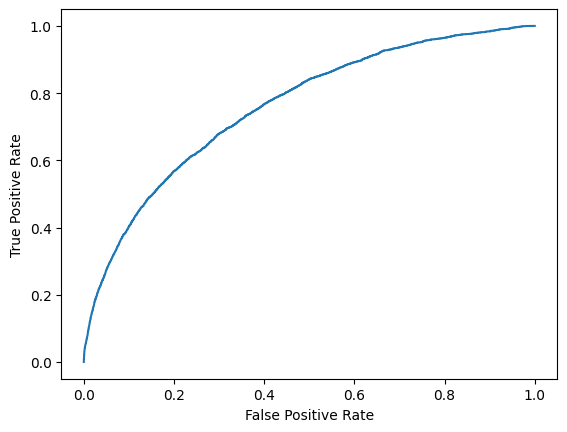

In [6]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve (y_val, val_preds)
auc = metrics.roc_auc_score (y_val, val_preds)

#create ROC curve
plt.plot (fpr,tpr,label=" AUC= "+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

## нейронка

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import pyarrow.parquet as pq

df = pq.read_table(source='train_ai_comp_final_dp.parquet').to_pandas()
# Предположим, что у вас уже есть данные df, подготовленные для обучения модели

# Класс для создания датасета PyTorch
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [29]:
X_train, X_val, y_train, y_val = train_test_split(df.drop(['target', 'id', 'sample_ml_new'], axis=1), df['target'], test_size=0.2, random_state=0)

In [31]:
x_tensor =  torch.from_numpy(X_train.values).float()
y_tensor =  torch.from_numpy(y_train.values.ravel()).float()
xtest_tensor =  torch.from_numpy(X_val.values).float()
ytest_tensor =  torch.from_numpy(y_val.values.ravel()).float()


In [32]:
from torch.utils.data import Dataset, TensorDataset

In [33]:
#Define a batch size , 
bs = 64
#Both x_train and y_train can be combined in a single TensorDataset, which will be easier to iterate over and slice
y_tensor = y_tensor.unsqueeze(1)
train_ds = TensorDataset(x_tensor, y_tensor)
#Pytorch’s DataLoader is responsible for managing batches. 
#You can create a DataLoader from any Dataset. DataLoader makes it easier to iterate over batches
train_dl = DataLoader(train_ds, batch_size=bs)


#For the validation/test dataset
ytest_tensor = ytest_tensor.unsqueeze(1)
test_ds = TensorDataset(xtest_tensor, ytest_tensor)
test_loader = DataLoader(test_ds, batch_size=32)

In [34]:
n_input_dim = X_train.shape[1]

#Layer size
n_hidden1 = 300  # Number of hidden nodes
n_hidden2 = 100
n_output =  1   # Number of output nodes = for binary classifier


class ChurnModel(nn.Module):
    def __init__(self):
        super(ChurnModel, self).__init__()
        self.layer_1 = nn.Linear(n_input_dim, n_hidden1) 
        self.layer_2 = nn.Linear(n_hidden1, n_hidden2)
        self.layer_out = nn.Linear(n_hidden2, n_output) 
        
        
        self.relu = nn.ReLU()
        self.sigmoid =  nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(n_hidden1)
        self.batchnorm2 = nn.BatchNorm1d(n_hidden2)
        
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.sigmoid(self.layer_out(x))
        
        return x
    

model = ChurnModel()
print(model)

ChurnModel(
  (layer_1): Linear(in_features=1076, out_features=300, bias=True)
  (layer_2): Linear(in_features=300, out_features=100, bias=True)
  (layer_out): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [35]:
loss_func = nn.BCELoss()
#Optimizer
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 50

In [36]:
model.train()
train_loss = []
for epoch in range(epochs):
    #Within each epoch run the subsets of data = batch sizes.
    for xb, yb in train_dl:
        y_pred = model(xb)            # Forward Propagation
        loss = loss_func(y_pred, yb)  # Loss Computation
        optimizer.zero_grad()         # Clearing all previous gradients, setting to zero 
        loss.backward()               # Back Propagation
        optimizer.step()              # Updating the parameters 
    #print("Loss in iteration :"+str(epoch)+" is: "+str(loss.item()))
    train_loss.append(loss.item())
print('Last iteration loss value: '+str(loss.item()))

RuntimeError: all elements of input should be between 0 and 1

In [21]:
import itertools

y_pred_list = []
model.eval()
#Since we don't need model to back propagate the gradients in test set we use torch.no_grad()
# reduces memory usage and speeds up computation
with torch.no_grad():
    for xb_test,yb_test  in test_loader:
        y_test_pred = model(xb_test)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.detach().numpy())

#Takes arrays and makes them list of list for each batch        
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
#flattens the lists in sequence
ytest_pred = list(itertools.chain.from_iterable(y_pred_list))

123213


RuntimeError: all elements of input should be between 0 and 1

In [3]:
y_true_test = test_y.values.ravel()
conf_matrix = confusion_matrix(y_true_test ,ytest_pred)
print("Confusion Matrix of the Test Set")
print("-----------")
print(conf_matrix)
print("Precision of the MLP :\t"+str(precision_score(y_true_test,ytest_pred)))
print("Recall of the MLP    :\t"+str(recall_score(y_true_test,ytest_pred)))
print("F1 Score of the Model :\t"+str(f1_score(y_true_test,ytest_pred)))


KeyboardInterrupt: 